# Sharpe Ratio
Author: Evan Azevedo   
Amberdata

In [2]:
# load the packages
import os
import requests
import warnings
import datetime as dt
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas_datareader as pdr

## Getting the Data

In [3]:
# helper functions
def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("./"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open(".env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception:
        return None
    
api_key = get_key()

### Daily Bitcoin Historical Sharpe Ratio

In [12]:
# our first token to try out
token = "btc"

# the url for our token
url = f"https://web3api.io/api/v2/market/metrics/{token}/historical/sharpe"

# our API key
headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}

# the start and end of the period
end = dt.datetime.today().isoformat()
start = (dt.datetime.today() + dt.timedelta(-365)).isoformat()
print("Start:", start, "\n", "End:", end)

# a querystring, indicating the time period
querystring = {
    "startDate": start,
    "endDate": end,
    "timeFrame": "1d"
}

# get the response
response = get_response(url, headers)
print("\nFirst five lines of the result:")
for i in range(5):
    print(response["data"][i])

Start: 2019-07-28T15:27:58.249032 
 End: 2020-07-27T15:27:58.248968

First five lines of the result:
['2019-07-29T00:00:00.000Z', 0.533128100455041, 0.17367362185965035]
['2019-07-30T00:00:00.000Z', 0.533128100455041, 0.17367362185965035]
['2019-07-31T00:00:00.000Z', 0.5328517690574035, 0.18011359801569535]
['2019-08-01T00:00:00.000Z', 0.5328284045265422, 0.18036005103267863]
['2019-08-02T00:00:00.000Z', 0.532827820305373, 0.18036633101052857]


### Plotting the Result

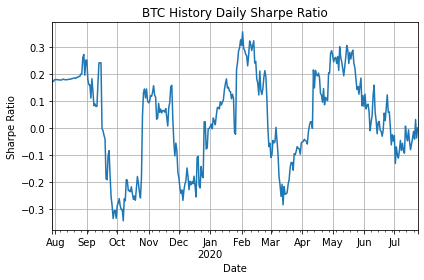

In [39]:
# load the data into a DataFrame and rename the columns
data = pd.DataFrame(response["data"]).rename({0: "date", 1: "volatility", 2: "sharpe"}, axis=1)
# turn the date column into datetime type
data["date"] = pd.to_datetime(data["date"])
# set the date as the index
data.set_index("date", inplace=True)

# plot the result
data.sharpe.plot()
plt.title(f"{token.upper()} History Daily Sharpe Ratio")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.tight_layout()
plt.grid(True)
plt.savefig("../plots/btc_daily_sharpe.png")
plt.show()

## Compare with Other Assets

In [40]:
# helper functions
def CAGR(DF):
    "Calculates the Compound Annual Growth Rate"
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['cum_return'] = (1 + df['daily_ret']).cumprod()
    return (df['cum_return'])**(252/len(df)) - 1

def volatility(DF):
    "Calculates the daily Volatility over a year, given we trade 252x a year"
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    vol = df['daily_ret'].std()*np.sqrt(252)
    return vol

def sharpe(DF, rf=None):
    "Sharpe ratio. RF = risk free rate. If not specified then rf=zero"
    df = DF.copy()
    if not rf:
        rf = np.array([0]*len(df))
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

In [44]:
# The S&P 500 Index
spy = pdr.get_data_yahoo("SPY", start, end)
# Gold futures
gold = pdr.get_data_yahoo("GC=F", start, end)
# Apple Stock
aapl = pdr.get_data_yahoo("AAPL", start, end)
# Bond index
bond = pdr.get_data_yahoo("BND", start, end)

In [45]:
# calculate the sharpe ratios
spy["sharpe"] = sharpe(spy)
gold["sharpe"] = sharpe(gold)
aapl["sharpe"] = sharpe(aapl)
bond["sharpe"] = sharpe(bond)

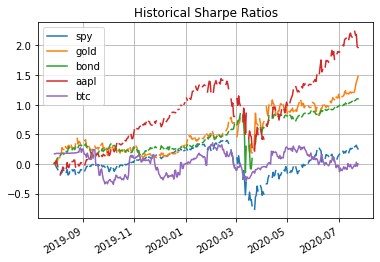

In [46]:
# combine the sharpe ratios into one dataframe
all_sharpe = pd.concat([spy.sharpe, gold.sharpe, bond.sharpe, aapl.sharpe, btc.sharpe], axis=1)
# rename the columns
all_sharpe.columns = ["spy", "gold", "bond", "aapl", "btc"]
# plot the result
all_sharpe.plot()
plt.title("Historical Sharpe Ratios")
plt.grid(True)
plt.savefig("../plots/asset_sharpes.png")

## Compare with Other Digital Assets

In [47]:
# helper functions
def to_df(response):
    "Turns the repsonse into a dataframe"
    # load the data into a DataFrame and rename the columns
    data = pd.DataFrame(response["data"]).rename({0: "date", 1: "volatility", 2: "sharpe"}, axis=1)
    # turn the date column into datetime type
    data["date"] = pd.to_datetime(data["date"])
    # set the date as the index
    data.set_index("date", inplace=True)
    return data

def get_sharpe(token):
    "Gets the Sharpe Ratio for the token"
    # the URL for the response
    url = f"https://web3api.io/api/v2/market/metrics/{token}/historical/sharpe"
    # get the response
    response = get_response(url, headers)
    try:
        return response
    except TypeError:
        print("No Response")

In [51]:
# market rankings URL
url = "https://web3api.io/api/v2/market/rankings"

# we want largest coins
querystring = {"sortType":"marketCap"}

# get the result
assets = get_response(url, headers, querystring)

# put the result in a dataframe
assets = pd.DataFrame(assets["data"])

# get the symbols of the top 10
top_10 = assets.iloc[:10, 10]

print(top_10)

0     btc
1     eth
2     xrp
3     CRO
4    LINK
5    USDT
6     xlm
7     bch
8     ada
9     bnb
Name: symbol, dtype: object


In [49]:
# to save the token names and results
tokens, results = [], {}

# the Sharpe Data querystring
querystring = {
    "startDate": start,
    "endDate": end,
    "timeFrame": "1d"
}

# lets iterate over the tokens of interest
for token in top_10:
    # get the token name in lower case
    token = token.lower()
    # get the result
    token_sharpe = get_sharpe(token)
    # if we got a response
    if token_sharpe:
        # if the response has data
        if token_sharpe["data"]:
            # save the token name
            tokens.append(token)
            # save the result as a dataframe
            results[token] = to_df(token_sharpe)

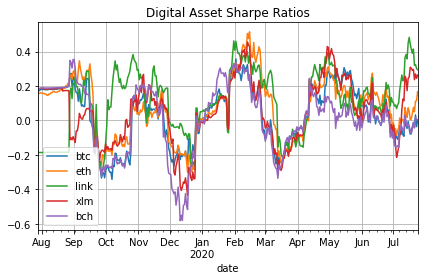

In [60]:
# join the results
coins = pd.concat([result.sharpe for result in results.values()], axis=1)
# rename the columns
coins.columns = tokens

# plot the results
coins.plot(legend="bottom")
plt.title("Digital Asset Sharpe Ratios")
plt.grid(True)
plt.legend(loc=3)
plt.tight_layout()
plt.savefig("../plots/da_sharpes.png")

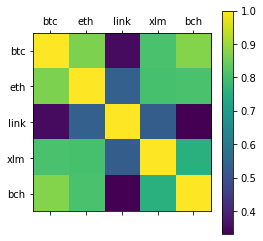

In [63]:
plt.matshow(coins.corr())
plt.xticks(range(len(coins.columns)), coins.columns)
plt.yticks(range(len(coins.columns)), coins.columns)
plt.colorbar()
plt.savefig("../plots/corr.png")
plt.show()

In [79]:
sim_max = coins.corr().iloc[1:, 0].argmax() + 1
print("Most similar returns to BTC:", coins.corr().columns[sim_max].upper())
print("\tCorrelation:", coins.corr().iloc[sim_max, 0])
print()
sim_min = coins.corr().iloc[1:, 0].argmin() + 1
print("Least similar returns to BTC:", coins.corr().columns[sim_min].upper())
print("\tCorrelation:", coins.corr().iloc[sim_min, 0])

Most similar returns to BTC: BCH
	Correlation: 0.8759413440119267

Least similar returns to BTC: LINK
	Correlation: 0.3508867644674271
